<a href="https://colab.research.google.com/github/xiao-zy19/stream/blob/precheck/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Upload "13features_clean.csv" and "apachePatientResult.csv" from computer

from google.colab import files
uploaded = files.upload()


Saving apachePatientResult.csv to apachePatientResult.csv


In [112]:
# Store patient dataset and mortality data in Pandas Dataframe

import pandas as pd

df = pd.read_csv('13features_cleaned.csv') # Replace filename with your computer's local file name

mortality_df = pd.read_csv('apachePatientResult.csv') # Replace filename with your computer's local file name
mortality_df = mortality_df[['patientunitstayid', 'actualicumortality']]
mortality_df = mortality_df.drop_duplicates(subset='patientunitstayid', keep='first')
mortality_df['actualicumortality'] = mortality_df['actualicumortality'].apply(lambda x: 0 if x == 'EXPIRED' else 1)


In [113]:
# Only keep first 24 hours data for each patient

df = df.groupby('patientunitstayid').apply(lambda x: x[x['observationoffset'] <= 24]).reset_index(drop=True)

# Merge the labels from morality_df dataset to the df dataset
merged_df = df.merge(mortality_df, on='patientunitstayid', how='left')

# Remove patients with missing mortality data
merged_df = merged_df.dropna(subset=['actualicumortality'])
df = merged_df



In [114]:
# Keep only 500 randomly selected patients
num_patients_to_keep = 500
if len(merged_df) > num_patients_to_keep:
    merged_df = merged_df.sample(n=num_patients_to_keep, random_state=42)

df = merged_df

# Create separate datasets for the patient data and labels

labels = df[['patientunitstayid','actualicumortality']]

patient_data = df.drop('actualicumortality',axis=1)

In [115]:
import random

# Split data into training and testing sets

# Get unique patientunitstayid's
unique_ids = patient_data['patientunitstayid'].unique()

# Randomly select 80% of the unique patientunitstayid's
selected_ids = random.sample(list(unique_ids), int(len(unique_ids) * 0.8))

# Filter the patient_data and labels DataFrames to only include selected patientunitstayid's
x_train = patient_data[patient_data['patientunitstayid'].isin(selected_ids)]
y_train = labels[labels['patientunitstayid'].isin(selected_ids)]

# Filter the patient_data and labels DataFrames to only include patientunitstayid's not in selected_ids for testing
x_test = patient_data[~patient_data['patientunitstayid'].isin(selected_ids)]
y_test = labels[~labels['patientunitstayid'].isin(selected_ids)]

# Drop the "patientunitstayid" column from y_train and y_test
y_train = y_train.drop('patientunitstayid', axis=1)
y_test = y_test.drop('patientunitstayid', axis=1)


In [116]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

logistic_model = LogisticRegression()
logistic_model.fit(x_train, y_train)

y_pred = logistic_model.predict(x_test)

accuracy = accuracy_score(y_test,y_pred)*100

confusion_mat = confusion_matrix(y_test,y_pred)

print("Accuracy is",accuracy)


Accuracy is 86.27450980392157


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


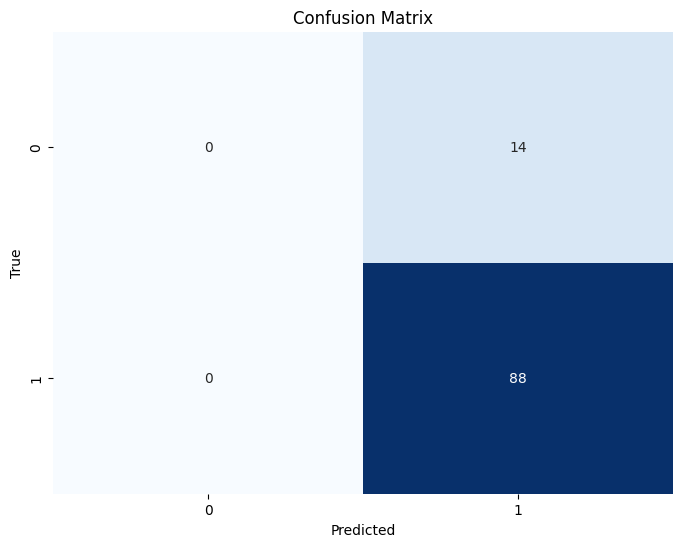

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


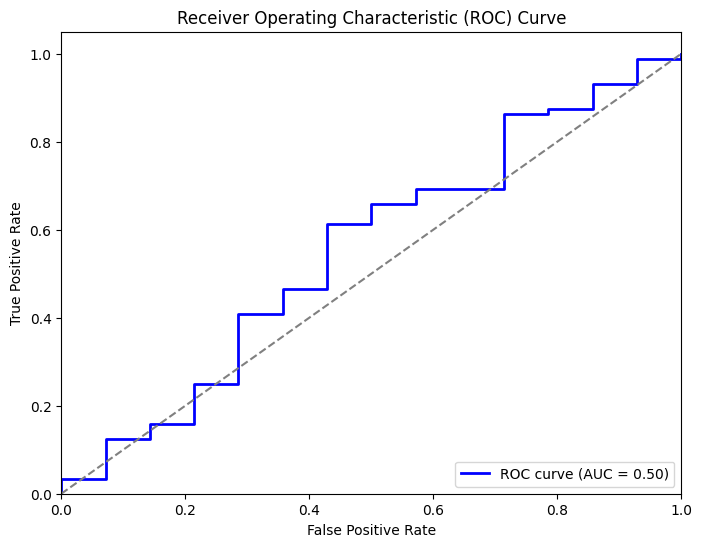

In [118]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, logistic_model.predict_proba(x_test)[:,1])
roc_auc = roc_auc_score(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


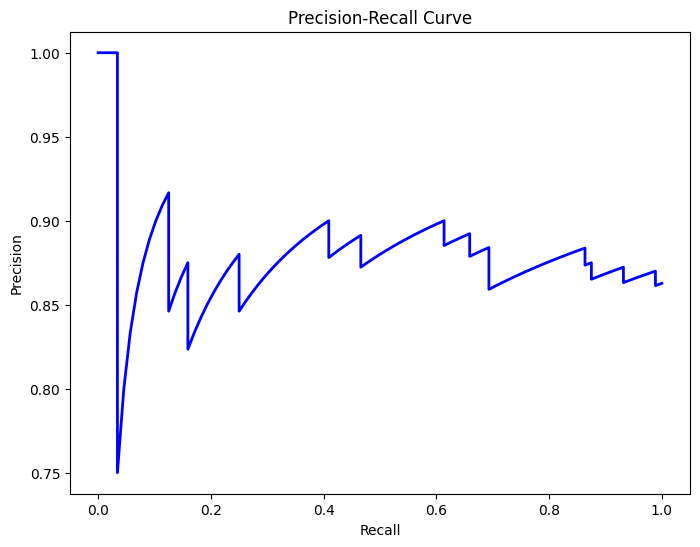

In [119]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, logistic_model.predict_proba(x_test)[:,1])

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
